In [2]:
import sys
sys.path.append("../../")

from tqdm import tqdm
import numpy as np

# Make sure tf does not hog all the GPU memory
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
x_train = np.load("/Users/smsharma/Downloads/halos_small.npy")[..., :3]
mean = np.mean(x_train, axis=(0,1))
std = np.std(x_train, axis=(0,1)) 

x_train = (x_train - mean) / std

In [12]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [13]:
from models.utils.equivariant_graph_utils import get_equivariant_graph
from models.utils.graph_utils import build_graph, compute_distances, nearest_neighbors
from models.segnn import SEGNN
from models.gnn import GNN
from models.utils.graph_utils import get_apply_pbc

In [26]:
import e3nn_jax as e3nn
from typing import Dict
import jax
from models.gnn import GNN
from models.segnn import SEGNN
from models.egnn import EGNN
from models.nequip import NequIP
import jraph
import jax.numpy as jnp

use_pbcs = True
apply_pbc = get_apply_pbc(std=std / 1000.,) if use_pbcs else None
k = 10
n_radial = 64
position_features = True
r_max = 0.6
use_3d_distances = False
l_max = 1

SEGNN_PARAMS = {
    "d_hidden": 128,
    "l_max_hidden": l_max,
    "n_layers": 3,
    "message_passing_steps": 3,
    "task": "graph",
    "output_irreps": e3nn.Irreps("1x0e"),
    "hidden_irreps": None,
    "message_passing_agg": "mean",
    "readout_agg": "mean",
    "n_outputs": 2,
    "scalar_activation": "gelu",
    "gate_activation": "sigmoid",
    "mlp_readout_widths": (4, 2, 2),
    "residual": False,
}

GNN_PARAMS = {
    "d_hidden": 128,
    "message_passing_steps": 3,
    "n_layers": 3,
    "activation": "gelu",
    "message_passing_agg": "mean",
    "readout_agg": "mean",
    "mlp_readout_widths": (4, 2, 2),
    "task": "graph",
    "n_outputs": 2,
    "norm": "none",
    "position_features": position_features,
    "residual": False,
}

NEQUIP_PARAMS = {
    "n_outputs": 2,
    "n_radial_basis": n_radial,
    "r_cutoff": r_max,
    "sphharm_norm": 'component',
}


class GraphWrapper(nn.Module):
    param_dict: Dict

    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
            velocities = None
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
            velocities = e3nn.IrrepsArray("1o", x.nodes[..., 3:6])

        
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=None,
            steerable_velocities=False,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=l_max,
            apply_pbc=apply_pbc,
            n_radial_basis=n_radial,
            r_max=r_max,
        )
        
        return jax.vmap(SEGNN(**self.param_dict))(st_graph)
    
class GraphWrapperGNN(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        return jax.vmap(GNN(**self.param_dict))(x)    

class GraphWrapperNequIP(nn.Module):
    param_dict: Dict

    @nn.compact
    def __call__(self, x):
        if x.nodes.shape[-1] == 3:
            ones = jnp.ones(x.nodes[..., :].shape[:2] + (1,))
            nodes = jnp.concatenate([x.nodes[..., :], x.nodes[..., :], ones], axis=-1)
            nodes = e3nn.IrrepsArray("1o + 1o + 1x0e", nodes)
        else:
            nodes = e3nn.IrrepsArray("1o + 1o + 1x0e", x.nodes[..., :])
        
        graph = jraph.GraphsTuple(
            n_node=x.n_node,
            n_edge=x.n_edge,
            edges=None,
            globals=x.globals,
            nodes=nodes, 
            senders=x.senders,
            receivers=x.receivers)
        
        return jax.vmap(NequIP(**self.param_dict))(graph)

In [27]:
graph = build_graph(x_train[:2], 
                None, 
                k=k, 
                apply_pbc=apply_pbc,
                use_edges=True, 
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
)

model = GraphWrapper(SEGNN_PARAMS, )

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)

# Number of parameters
print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")

out

Number of parameters: 573253


/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9853/1825512499.py:16: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")


Array([[-0.00502239, -0.00011915],
       [-0.00469782, -0.00013022]], dtype=float32)

In [28]:
model = GraphWrapperGNN(GNN_PARAMS)

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)

# Number of parameters
print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")

out

Number of parameters: 700674


/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9853/1152665868.py:6: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")


Array([[ 0.16024624, -0.09174243],
       [ 0.1541301 , -0.07500153]], dtype=float32)

In [29]:
model = GraphWrapperNequIP(NEQUIP_PARAMS)

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)

# Number of parameters
print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")

out

Number of parameters: 393216


/var/folders/nx/bx2847k56j3dddp761x637pc0000gn/T/ipykernel_9853/2023141262.py:6: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")


Array([[-0.9241759 , -0.74314517],
       [-0.5319379 , -0.60047907]], dtype=float32)

In [457]:
# from models.transformer import Transformer

# model = Transformer(task="graph", n_outputs=2, induced_attention=True, n_inducing_points=256, readout_agg="attn")

# rng = jax.random.PRNGKey(0)
# out, params = model.init_with_output(rng, x_train[:2])

# out

In [458]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [459]:
# Define train state and replicate across devices

# Cosine learning rate schedule
lr = optax.cosine_decay_schedule(3e-4, 2000)
# lr = optax.warmup_cosine_decay_schedule(
#     init_value=0.0,
#     peak_value=3e-4,
#     warmup_steps=500,
#     decay_steps=5000,
# )

# lr = optax.linear_onecycle"_schedule(5000, 3e-4)
tx = optax.adamw(learning_rate=lr, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [460]:
def loss_mse(pred_batch, cosmo_batch,):
    return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    halo_graph = build_graph(halo_batch, 
                None, 
                k=k, 
                use_edges=True, 
                apply_pbc=apply_pbc,
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
    )
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [461]:
n_steps = 2000
n_batch = 32

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x_train.shape[0], shape=(n_batch,))
        
        halo_batch, cosmo_batch = x_train[idx], params_train[idx]

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipykernel_3792805/1390803243.py:14: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_3792805/1390803243.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
  0%|          | 1/2000 [00:22<12:17:57, 22.15s/it, loss=56.42363]/tmp/ipykernel_3792805/1390803243.py:14: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_3792805/1390803243.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree

100%|██████████| 3/3 [00:18<00:00,  6.16s/it]

Mean MSE: 0.5052722096443176


Text(0, 0.5, 'Predicted')

<Figure size 1200x600 with 0 Axes>

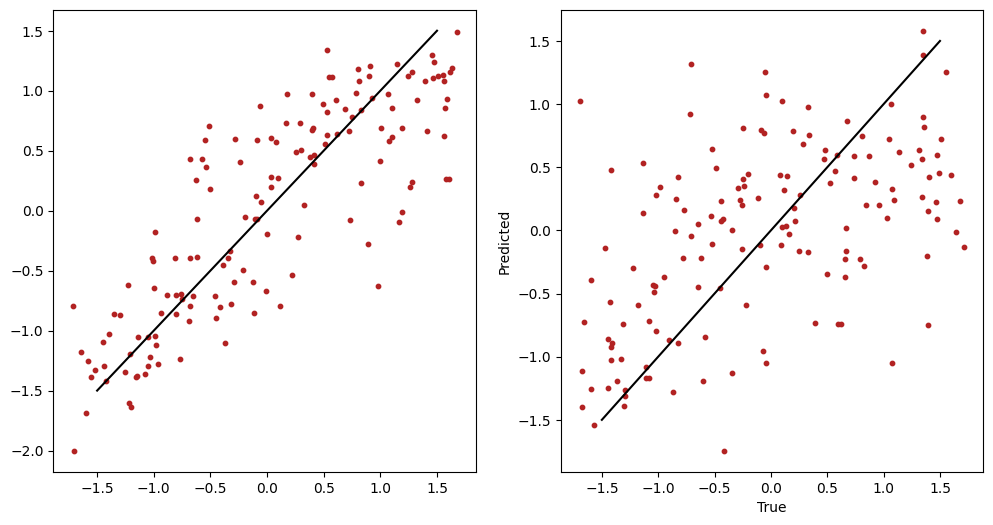

In [462]:
import matplotlib.pyplot as plt

features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']

dataset, num_total = get_halo_dataset(batch_size=50,  # Batch size
                            num_samples=250,  # If not None, will only take a subset of the dataset
                            split='val',  # 'train', 'val'
                            standardize=True,  # If True, will standardize the features
                            return_mean_std=False,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                            seed=42,  # Random seed
                            features=features,  # Features to include
                            params=params  # Parameters to include
                            )

iterator = iter(dataset)

plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

mse_list = []

x_val, params_val = [], []
for _ in tqdm(range(num_total // batch_size)):
    x, params = next(iterator)

    # Convert to numpy
    x, params = np.array(x), np.array(params)
    
    # x_val.append(np.array(x))
    # params_val.append(np.array(params))

    graph = build_graph(x, 
                None, 
                k=k, 
                use_edges=True, 
                apply_pbc=apply_pbc,
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
                )

    pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    ax[0].scatter(params[:, 0], pred[:, 0], s=10, color='firebrick')
    ax[1].scatter(params[:, 1], pred[:, 1], s=10, color='firebrick')

    mse = np.mean((pred - params) ** 2)
    mse_list.append(mse)

# Diagonal
ax[0].plot([-1.5, 1.5], [-1.5, 1.5], color='black')
ax[1].plot([-1.5, 1.5], [-1.5, 1.5], color='black')

print(f"Mean MSE: {np.mean(mse_list)}")

# # # Diagonal line
# plt.plot([0, 0.5], [0, 0.5])

plt.xlabel("True")
plt.ylabel("Predicted")

In [92]:
# x_test = np.load("../../../BNN_SBI/data/set_diffuser_data/test_halos.npy")[..., :3] / 1000.
# params_test = pd.read_csv("../../../BNN_SBI/data/set_diffuser_data/test_cosmology.csv",)

# params_test = params_test[["Omega_m", "sigma_8"]].values

# x_test = (x_test - mean) / std
# params_test = (params_test - mean_params) / std_params

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

Mean MSE: 0.1213223785161972


Text(0, 0.5, 'Predicted')

<Figure size 1200x600 with 0 Axes>

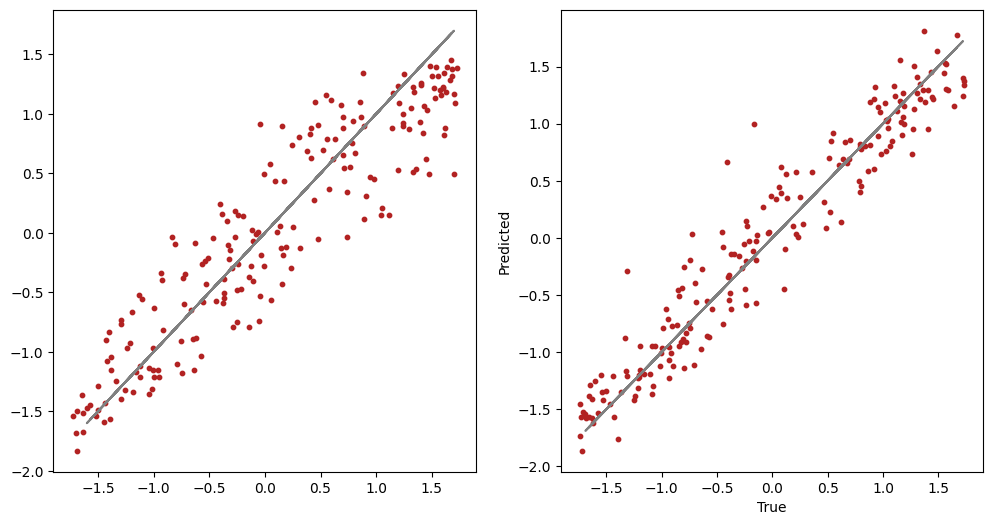

In [ ]:
from tqdm import tqdm

n_test_batch = 50
n_test_batches = len(x_test) // n_test_batch

# Make two plots side by side for 0 and 1 idx parameters

plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

mse_list = []

for i in tqdm(range(n_test_batches)):

    # TODO: jit/pmap
    graph = build_graph(x_test[i * n_test_batch:(i + 1) * n_test_batch], 
                        None, 
                        k=k, 
                        use_edges=True, 
                        apply_pbc=apply_pbc,
                        n_radial_basis=n_radial,
                        )

    
    omega_m_pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    ax[0].scatter(params_test[i * n_test_batch:(i + 1) * n_test_batch, 0], omega_m_pred[:, 0], s=10, color='firebrick')
    ax[1].scatter(params_test[i * n_test_batch:(i + 1) * n_test_batch, 1], omega_m_pred[:, 1], s=10, color='firebrick')

    mse_list.append(loss_mse(omega_m_pred, params_test[i * n_test_batch:(i + 1) * n_test_batch]))

print(f"Mean MSE: {np.mean(mse_list)}")
    
ax[0].plot(params_test[:n_test_batch, 0], params_test[:n_test_batch, 0], color='gray')
ax[1].plot(params_test[:n_test_batch, 1], params_test[:n_test_batch, 1], color='gray')

plt.xlabel("True")
plt.ylabel("Predicted")